In [44]:
import rasterio as rio
from rasterio.enums import Resampling
from rasterio import Affine, MemoryFile
from rasterio.warp import transform
import os
import matplotlib.pyplot as plt
import gdal
import numpy as np
from multiprocessing.dummy import Pool as ThreadPool
import subprocess
import sys
import glob
import plotly.offline as pyo
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from contextlib import contextmanager
import xarray as xr
from memory_profiler import memory_usage

%load_ext memory_profiler
init_notebook_mode()

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


### Get path to Eswatini data

Data downloaded from https://data.humdata.org/

In [45]:
cwd = os.getcwd()
filepath = cwd+"/data/population_swz_2019-07-01.tif" 
dataset = rio.open(filepath,"r+")


### The Eswatini dataset is population data at 30m x 30m resolution. The code below resamples to a courser 3km x 3km grid, and saves to a text file which the c++ code can read.

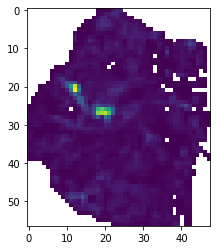

In [46]:
upscale_factor = 1/100.0

X = dataset.read(1)
nx = int(upscale_factor*X.shape[0])
ny = int(upscale_factor*X.shape[1])
Y = np.zeros((nx,ny))
for i in range(nx):
    for j in range(ny):
        s = np.nansum(X[100*i:100*(i+1)-1,100*j:100*(j+1)-1])
        if s == 0:
            Y[i,j] = np.nan
        else:
            Y[i,j] = s
            
outfile = cwd+'/data/swz.txt'
myfile = open(outfile, 'w')
count = 0
for i in range(nx):
    for j in range(ny):
        if data[i,j]==data[i,j]:
            count+=1
            #print(i,j,int(data[i,j]))
            myfile.write(str(i)+" "+str(j)+" "+str(int(data[i,j]))+"\n")
myfile.close()

# plot data - grid cells with 0 population are given nan values, and plotted as white.
plt.imshow(data)        


### The below function runs parasim, which we use with N repeats in parallel on four threads

In [47]:
def run_parasim(i):
    ccmd = "bin/runner 1"
    proc = subprocess.Popen(ccmd,shell=True,stdout=subprocess.PIPE)
    data = proc.communicate()[0]
    return data

In [48]:
N = 4
my_array = range(N)
pool = ThreadPool(4)
%memit results = pool.map(run_parasim, my_array)

peak memory: 675.29 MiB, increment: 0.16 MiB


### We now parse the results, and reformat into arrays for plotting

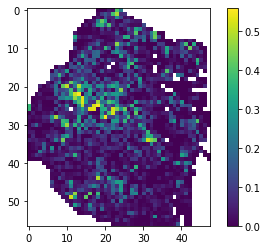

In [49]:
# 50 years of data
L = 50

# n non-zero subpopulations
n = np.sum(np.isfinite(data))

# parse data as 1D arrays and take the mean
A = []
for i in range(50):
    start = i*(n+1) + 1 +2
    stop = (i)*(n+1) + (n+1) +2
    temp = np.zeros(n)
    for j in range(N):
        datas = np.asarray(results[j].split())
        temp = temp + (1.0/N)*datas[start:stop].astype(float)
    A.append(temp)

# reshape arrays into grid and include nan-values for cells with 0 population
D = []
for k in range(50):
    swz = np.nan*np.ones(data.shape)
    count=0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i,j]==data[i,j]:
                swz[i,j]=A[k][count]
                count+=1

    D.append(swz)
    
plt.imshow(D[20])
plt.colorbar()

### We can animate the results using plotly heamaps

In [50]:
x = np.linspace(0,1, D[0].shape[1])
y = np.linspace(0,1, D[0].shape[0])
xx, yy = np.meshgrid(x, y)
c_scale = 'ylorrd'

trace = go.Heatmap(
    x=x,
    y=y,
    z=np.flip(D[0],0),
    colorscale=c_scale,
    colorbar=dict(title="Prevalence",
                                 titlefont=dict(size=13),
                                thicknessmode="pixels",
                                thickness=25)
)


frames = [{
        'data': [{'z': np.flip(D[i],0),
                 'type': 'heatmap',
                 'zmin': 0,
                 'zmax':np.max(A),
                 'colorscale':c_scale,
                 'colorbar':dict(title="Prevalence",
                                 titlefont=dict(size=13),
                                thicknessmode="pixels",
                                thickness=25,
                                xanchor='left')}],
        'layout':go.Layout(title=" Year: "+str(i+2020))} for i in range(len(D))]


layout = dict(plot_bgcolor='midnightblue',
              autosize=False,
              height=600,
              width=600,
              hovermode='closest',
              xaxis=dict(range=[-0.05, 1.05], autorange=False),
              yaxis=dict(range=[-0.05, 1.05], autorange=False),
              showlegend=False,
#              sliders = [sliders_dict],
              updatemenus=[dict(type='buttons', showactive=True,
                                y=1, x=-0.05, xanchor='right',
                                yanchor='top', pad=dict(t=0, r=10),
                                buttons=[dict(label='Play',
                                              method='animate',
                                              args=[None,
                                                    dict(frame=dict(duration=50,
                                                                    redraw=True),
                                                    transition=dict(duration=50),
                                                    fromcurrent=False,
                                                    mode='immediate')]),
                                         dict(label='Pause',
                                              method='animate',
                                              args=[None,
                                                    dict(frame=dict(duration=0,redraw=False),
                                                    transition=dict(duration=0),
                                                    fromcurrent=False,
                                                    mode='immediate')])])])
axis_template = dict(autorange = False,
             showgrid = False, zeroline = False,
             showticklabels = False,
             ticks = '')

plot_data=[trace]
fig1 = go.Figure(data=plot_data, frames=frames, layout=layout);
fig1.update_layout(
    xaxis = axis_template,
    yaxis = axis_template,
    annotations=[
        dict(
            x=-0.03,
            y=1.0,
            #xref="x",
            #yref="y",
            font = dict(color='white',size=12),
            xanchor='left',
            yanchor='bottom',
            text="Eswatini",
            showarrow=False
        )
    ],
);

In [51]:
fig1.show(renderer="notebook_connected")

### Plotly also allows us to overlay the heatmap onto a geographical map, using lat/long coordinates from the original geotiff file

In [52]:
# Example licensed under cc by-sa 3.0 with attribution required
# use context manager so DatasetReader and MemoryFile get cleaned up automatically
@contextmanager
def resample_raster(raster, scale=2.0):
    t = raster.transform

    # rescale the metadata
    transform = rio.Affine(t.a / scale, t.b, t.c, t.d, t.e / scale, t.f)
    height = int(raster.height * scale)
    width = int(raster.width * scale)

    profile = src.profile
    profile.update(transform=transform, driver='GTiff', height=height, width=width)

    data = raster.read( # Note changed order of indexes, arrays are band, row, col order not row, col, band
            out_shape=(raster.count, height, width),
            resampling=Resampling.bilinear,
        )

    with MemoryFile() as memfile:
        with memfile.open(**profile) as dataset: # Open as DatasetWriter
            dataset.write(data)
            del data
            
        with memfile.open() as dataset:  # Reopen as DatasetReader
            yield dataset  # Note yield not return     

 

### First lets plot the population density

In [57]:
with rio.open(filepath) as src:
    with resample_raster(src,scale=1/100.0) as resampled:
        #print('Orig dims: {}, New dims: {}'.format(src.shape, resampled.shape))

        da = xr.open_rasterio(resampled)
        # Compute the lon/lat coordinates with rasterio.warp.transform
        ny, nx = len(da['y']), len(da['x'])
        x, y = np.meshgrid(da['x'], da['y'])

        # Rasterio works with 1D arrays
        lon, lat = rio.warp.transform(da.crs, {'init': 'EPSG:4326'},x.flatten(), y.flatten())
        z = np.asarray(Y).flatten()

        
        fig2 = go.Figure(go.Densitymapbox(lat=lat, lon=lon, z=z,
                                 radius=10))
        fig2.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=31.5,mapbox_center_lat=-26.5,mapbox_zoom=7.5)
        fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig2.update_layout(              autosize=False,
              height=600,
              width=600)
        fig2.show(renderer="notebook_connected")


### And next a prevalence map

In [59]:
fig3 = go.Figure(go.Densitymapbox(lat=lat, lon=lon, z=z,
                                 radius=10,colorscale=c_scale))

with rio.open(filepath) as src:
    with resample_raster(src,scale=1/100.0) as resampled:
        #print('Orig dims: {}, New dims: {}'.format(src.shape, resampled.shape))

        da = xr.open_rasterio(resampled)
        # Compute the lon/lat coordinates with rasterio.warp.transform
        ny, nx = len(da['y']), len(da['x'])
        x, y = np.meshgrid(da['x'], da['y'])

        # Rasterio works with 1D arrays
        lon, lat = rio.warp.transform(da.crs, {'init': 'EPSG:4326'},x.flatten(), y.flatten())
        z = np.asarray(D[40]).flatten()

        fig3.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=31.5,mapbox_center_lat=-26.5,mapbox_zoom=7.5)
        fig3.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig3.update_layout(              autosize=False,
              height=600,
              width=600)

fig3.show(renderer="notebook_connected")


### Note: these maps can also be animated 